In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_data = pd.read_csv("train.csv", engine='python', encoding='utf-8', on_bad_lines='skip')
val_data = pd.read_csv("val.csv", engine='python', encoding='utf-8', on_bad_lines='skip')
test_data = pd.read_csv("test.csv", engine='python', encoding='utf-8', on_bad_lines='skip')

train_data['body_length'] = train_data['body'].astype(str).apply(len)
val_data['body_length'] = val_data['body'].astype(str).apply(len)
test_data['body_length'] = test_data['body'].astype(str).apply(len)

train_data['created_utc'] = pd.to_datetime(train_data['created_utc'], unit='s')
val_data['created_utc'] = pd.to_datetime(val_data['created_utc'], unit='s')
test_data['created_utc'] = pd.to_datetime(test_data['created_utc'], unit='s')

train_data['post_hour'] = train_data['created_utc'].dt.hour
val_data['post_hour'] = val_data['created_utc'].dt.hour
test_data['post_hour'] = test_data['created_utc'].dt.hour

features = ['ups', 'downs', 'body_length', 'post_hour']
target = 'score'  # Assuming 'score' is the popularity target

X_train = train_data[features]
y_train = train_data[target]

X_val = val_data[features]
y_val = val_data[target]

X_test = test_data[features]
y_test = test_data[target]

for col in features:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

y_train = pd.to_numeric(y_train, errors='coerce')
y_val = pd.to_numeric(y_val, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# Fill missing values with mean
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean())
X_test = X_test.fillna(X_test.mean())

y_train = y_train.fillna(y_train.mean())
y_val = y_val.fillna(y_val.mean())
y_test = y_test.fillna(y_test.mean())

def add_engineered_features(df):
    df = df.copy()
    df['ups_downs_product'] = df['ups'] * df['downs']
    df['ups_squared'] = df['ups'] ** 2
    df['body_hour_interaction'] = df['body_length'] * df['post_hour']
    
    # Log transform only non-negative numbers
    df['ups_log'] = np.log1p(df['ups'].clip(lower=0))
    df['downs_log'] = np.log1p(df['downs'].clip(lower=0))
    
    # Safely compute ups_to_downs
    df['ups_to_downs'] = df['ups'] / (df['downs'] + 1)
    
    # Replace any remaining infinities or NaNs with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

X_train_enhanced = add_engineered_features(X_train)
X_val_enhanced = add_engineered_features(X_val)
X_test_enhanced = add_engineered_features(X_test)



C:\Users\DEESHA\AppData\Local\Temp\ipykernel_10128\1959625093.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
C:\Users\DEESHA\AppData\Local\Temp\ipykernel_10128\1959625093.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
C:\Users\DEESHA\AppData\Local\Temp\ipykernel_10128\1959625093.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

✅ Linear Regression trained successfully. MSE=705.9663, MAE=7.1325
✅ Random Forest trained successfully. MSE=2.5216, MAE=0.0134
✅ Gradient Boosting trained successfully. MSE=4.1768, MAE=0.0150

📊 Model Performance Comparison:
               Model         MSE       MAE
1      Random Forest    2.521619  0.013446
2  Gradient Boosting    4.176755  0.015016
0  Linear Regression  705.966326  7.132534

🏆 Best Model: Random Forest
Test MSE: 0.5490, Test MAE: 0.0101


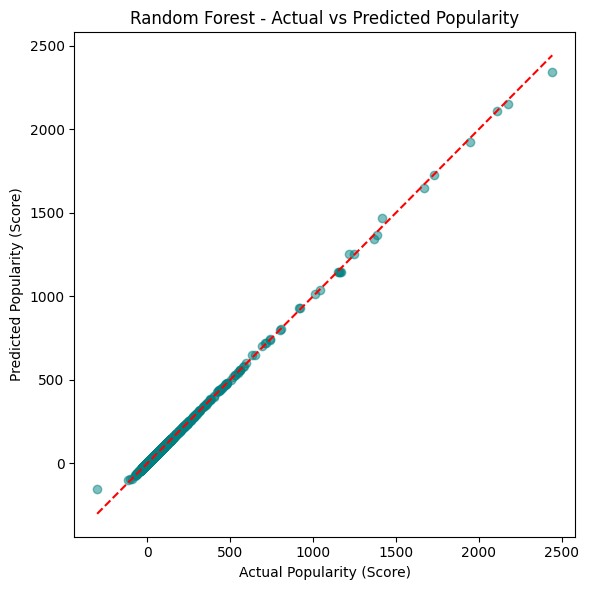

C:\Users\DEESHA\AppData\Local\Temp\ipykernel_10128\203922186.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10], palette="viridis")


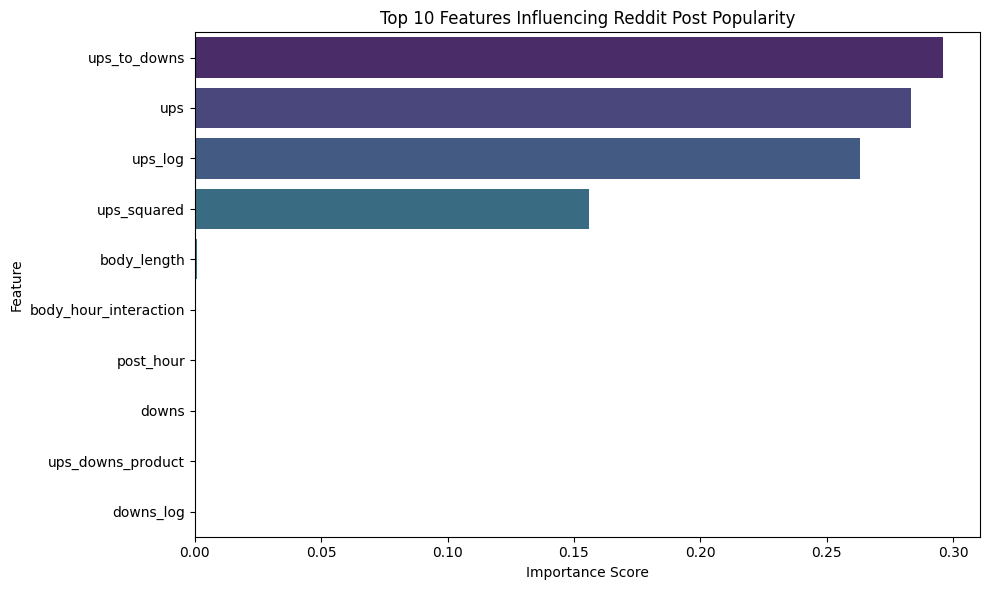

In [3]:
# ============================================================
# STEP 4: SCALING
# ============================================================
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_enhanced)
X_val_scaled = scaler.transform(X_val_enhanced)
X_test_scaled = scaler.transform(X_test_enhanced)

# ============================================================
# STEP 5: MODEL TRAINING AND EVALUATION
# ============================================================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, preds)
    mae = mean_absolute_error(y_val, preds)
    results.append({"Model": name, "MSE": mse, "MAE": mae})
    print(f"✅ {name} trained successfully. MSE={mse:.4f}, MAE={mae:.4f}")

results_df = pd.DataFrame(results).sort_values(by="MSE")
print("\n📊 Model Performance Comparison:")
print(results_df)

# ============================================================
# STEP 6: TEST EVALUATION (Best Model)
# ============================================================
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

best_model.fit(X_train_scaled, y_train)
pred_test = best_model.predict(X_test_scaled)

mse_test = mean_squared_error(y_test, pred_test)
mae_test = mean_absolute_error(y_test, pred_test)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Test MSE: {mse_test:.4f}, Test MAE: {mae_test:.4f}")

# ============================================================
# STEP 7: VISUAL INSIGHTS
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Actual vs Predicted Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_test, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Popularity (Score)")
plt.ylabel("Predicted Popularity (Score)")
plt.title(f"{best_model_name} - Actual vs Predicted Popularity")
plt.tight_layout()
plt.show()

# 2️⃣ Feature Importance (if model supports it)
if hasattr(best_model, "feature_importances_"):
    feat_imp = pd.Series(best_model.feature_importances_, index=X_train_enhanced.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10], palette="viridis")
    plt.title("Top 10 Features Influencing Reddit Post Popularity")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()



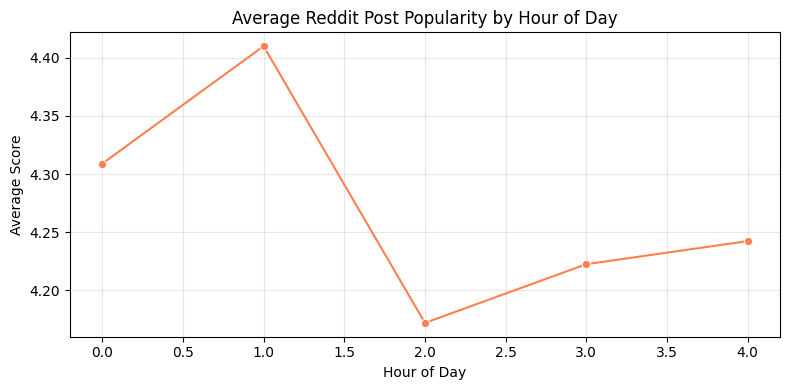

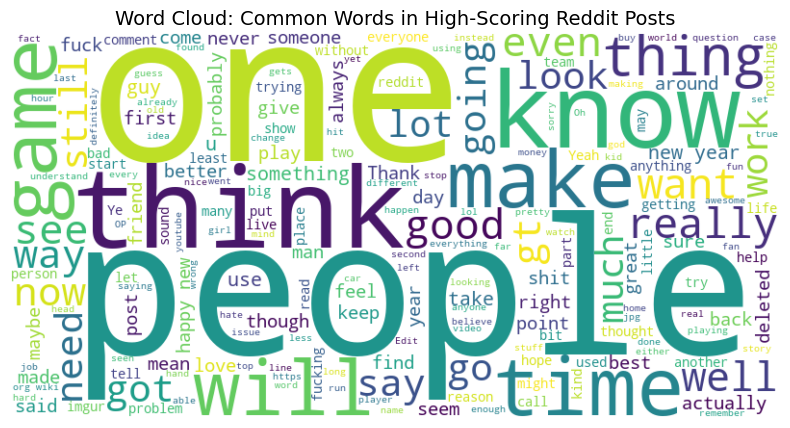


📈 Summary:
Best performing model: Random Forest

Top Features Influencing Popularity:
ups_to_downs    0.295862
ups             0.283313
ups_log         0.263318
ups_squared     0.156037
body_length     0.000931
dtype: float64

✅ Visualizations and insights generated successfully!


In [8]:
# ============================================================
# 3️⃣ Posting Hour vs Average Score
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric values for post_hour and score
train_data['post_hour'] = pd.to_numeric(train_data['post_hour'], errors='coerce')
train_data['score'] = pd.to_numeric(train_data['score'], errors='coerce')

# Drop rows with missing values before grouping
hourly_trend = (
    train_data.dropna(subset=['post_hour', 'score'])
    .groupby('post_hour')['score']
    .mean()
)

# Plot trend
plt.figure(figsize=(8, 4))
sns.lineplot(x=hourly_trend.index, y=hourly_trend.values, marker="o", color='coral')
plt.title("Average Reddit Post Popularity by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Score")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# STEP 8: CREATIVE VISUAL (WORD CLOUD)
# ============================================================
try:
    from wordcloud import WordCloud

    # Convert score to numeric to avoid comparison issues
    train_data['score'] = pd.to_numeric(train_data['score'], errors='coerce')

    # Filter high-scoring posts (above median)
    high_score_posts = train_data.dropna(subset=['score', 'body'])
    high_score_posts = high_score_posts.loc[
        high_score_posts['score'] > high_score_posts['score'].median()
    ]

    # Combine post text
    high_score_text = " ".join(high_score_posts['body'].astype(str))

    # Generate and display word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(high_score_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud: Common Words in High-Scoring Reddit Posts", fontsize=14)
    plt.show()

except ModuleNotFoundError:
    print("⚠️ WordCloud not installed. Run `pip install wordcloud` to see this visualization.")


# ============================================================
# STEP 9: SUMMARY INSIGHT
# ============================================================
print("\n📈 Summary:")
print(f"Best performing model: {best_model_name}")

if 'feat_imp' in locals():
    print("\nTop Features Influencing Popularity:")
    print(feat_imp.head(5))

print("\n✅ Visualizations and insights generated successfully!")
